In [1]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st
import dynamo as dyn
import cv2
import anndata
import pandas as pd
from scipy import stats

import scanpy as sc

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

st.configuration.set_pub_style_mpltex()

%matplotlib inline

/Users/jingzehua/Desktop/Projects/spateo-dev/spateo-release/spateo/configuration.py:371: UserWarning: Trying to register the cmap 'fire' which already exists.
  plt.register_cmap("fire", fire_cmap)
/Users/jingzehua/Desktop/Projects/spateo-dev/spateo-release/spateo/configuration.py:372: UserWarning: Trying to register the cmap 'darkblue' which already exists.
  plt.register_cmap("darkblue", darkblue_cmap)
/Users/jingzehua/Desktop/Projects/spateo-dev/spateo-release/spateo/configuration.py:373: UserWarning: Trying to register the cmap 'darkgreen' which already exists.
  plt.register_cmap("darkgreen", darkgreen_cmap)
/Users/jingzehua/Desktop/Projects/spateo-dev/spateo-release/spateo/configuration.py:374: UserWarning: Trying to register the cmap 'darkred' which already exists.
  plt.register_cmap("darkred", darkred_cmap)
/Users/jingzehua/Desktop/Projects/spateo-dev/spateo-release/spateo/configuration.py:375: UserWarning: Trying to register the cmap 'darkpurple' which already exists.
  plt.r

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


Get Anndata Object

In [2]:
#set file path
mtx_path = "matrix.txt"
tif_path = ""
seg_path = "full_segmentation.h5ad"
cell_label_path = "adata_X_labels.h5ad"

In [3]:
#load cell segmentation anndata
cell_label_adata = anndata.read(cell_label_path)
cell_label_adata

AnnData object with n_obs × n_vars = 12618 × 25691
    obs: 'area'
    uns: '__type', 'spatial'
    obsm: 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [66]:
#binning data
%%time
adata = st.io.read_bgi(
    mtx_path,
    binsize=60
)

|-----> Using binsize=40
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.
CPU times: user 30.8 s, sys: 1.06 s, total: 31.8 s
Wall time: 31.7 s


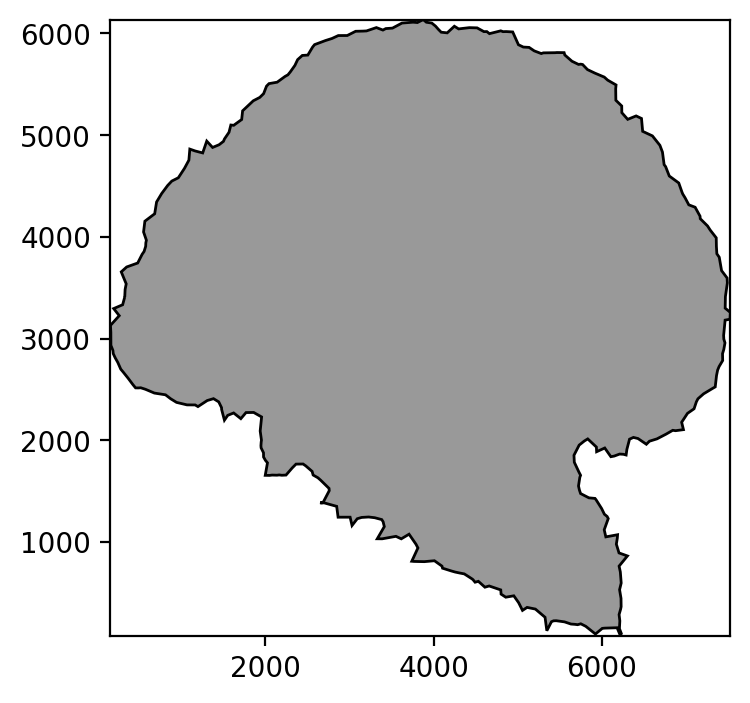

In [67]:
#get main concave hull
alpha1 = st.io.alpha_shape(cell_label_adata.obsm['spatial'][:,0],
                           cell_label_adata.obsm['spatial'][:,1],
                           alpha=0.012)
#st.pl.polygon(alpha1[0], figsize=(4, 4))
st.pl.polygon(alpha1[0][3], figsize=(4, 4))

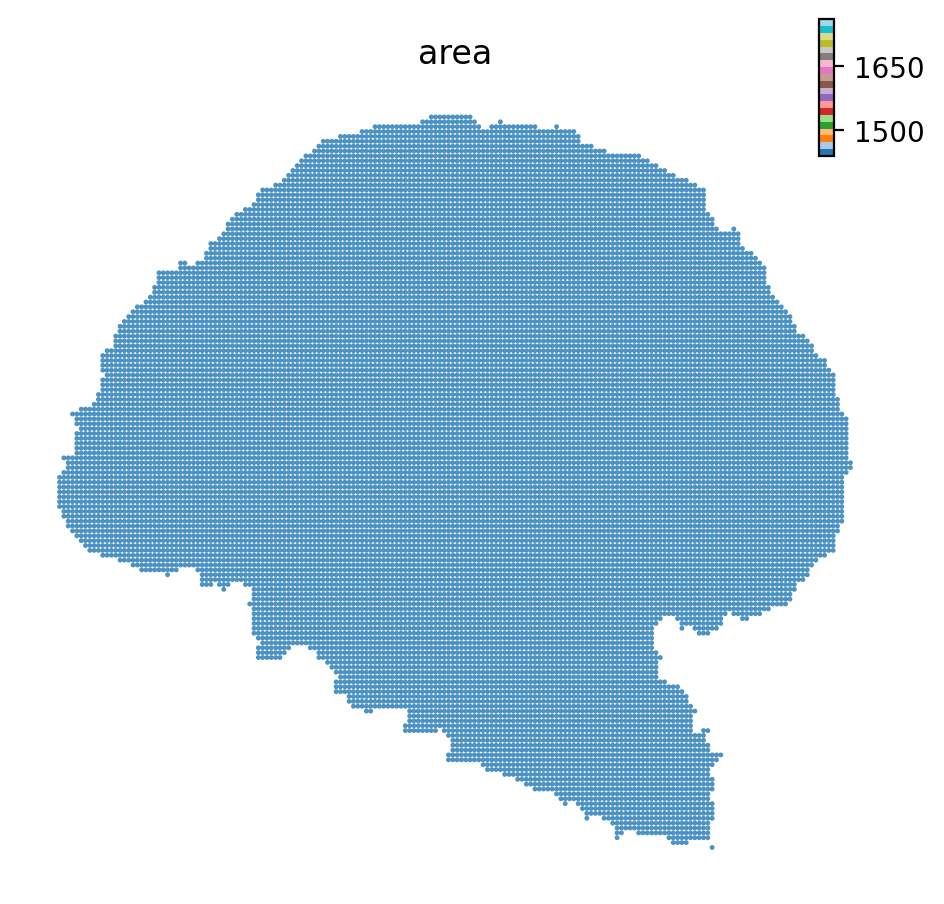

In [68]:
#mask the data and save
adata = adata[st.io.utils.in_concave_hull(adata.obsm['spatial'], alpha1[0][3]), :]
st.pl.space(adata, color=['area'], pointsize=0.1, show_legend="upper left", cmap="tab20")
adata.write('adata_bin60_concave_hull_ver.h5ad', compression='gzip')

In [86]:
#load binning anndata
adata = anndata.read('adata_bin60_concave_hull_ver.h5ad')
adata

AnnData object with n_obs × n_vars = 7765 × 25691
    obs: 'area'
    uns: '__type', 'spatial'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [87]:
#preprocessing
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.uns["pp"] = {}
adata.var_names_make_unique()
st.pp.filter.filter_genes(adata, min_cells=3)

AnnData object with n_obs × n_vars = 7765 × 21667
    obs: 'area', 'n_counts'
    var: 'pass_basic_filter'
    uns: '__type', 'spatial', 'pp'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [88]:
#normalization
dyn.pp.normalize_cell_expr_by_size_factors(adata, layers="X")
dyn.pp.log1p(adata)

|-----> rounding expression data of layer: X during size factor calculation
|-----> size factor normalize following layers: ['X']
|-----> applying <ufunc 'log1p'> to layer<X>
|-----> set adata <X> to normalized data.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----> log1p transform applied to layers: ['X']


AnnData object with n_obs × n_vars = 7765 × 25691
    obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size'
    uns: '__type', 'spatial', 'pp'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [111]:
#linear reduction
st.tl.pca_spateo(adata, n_pca_components=50)
adata

|-----> Runing PCA on adata.X...


AnnData object with n_obs × n_vars = 7765 × 25691
    obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'scc'
    uns: '__type', 'spatial', 'pp', 'neighbors', 'louvain', 'louvain_colors', 'spatial_neighbors', 'scc', 'scc_colors'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial', 'X_pca'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities', 'spatial_distances', 'spatial_connectivities'

In [109]:
#identify neighbors(KNN)
dyn.tl.neighbors(adata, n_neighbors=30)
adata

|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.


AnnData object with n_obs × n_vars = 7765 × 25691
    obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'scc'
    uns: '__type', 'spatial', 'pp', 'neighbors', 'louvain', 'louvain_colors', 'spatial_neighbors', 'scc', 'scc_colors'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial', 'X_pca'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities', 'spatial_distances', 'spatial_connectivities'

|-----> accessing adj_matrix_key=distances built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to networkx object
|-----> [Community clustering with louvain] in progress: 100.0000%
|-----> [Community clustering with louvain] finished [27.4357s]


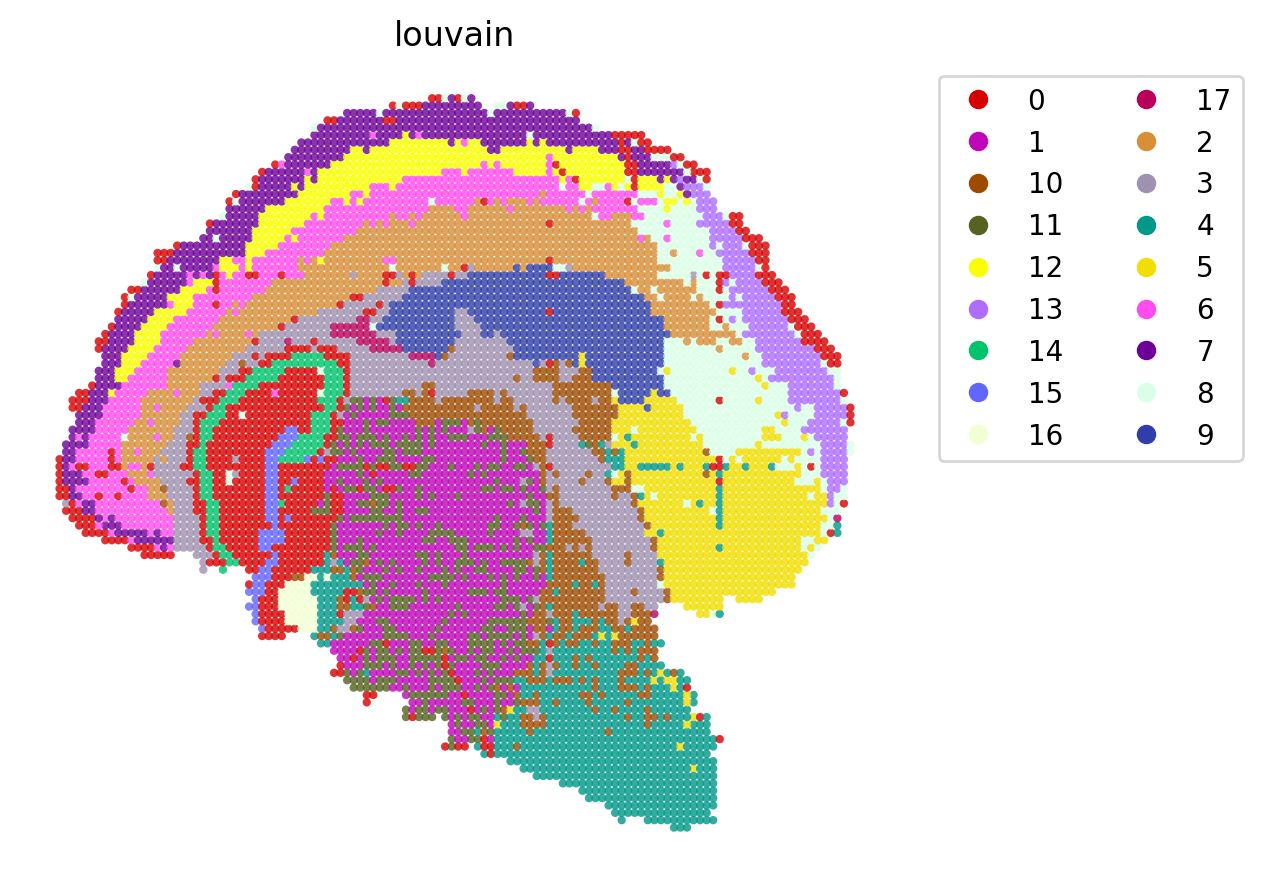

In [130]:
#louvain clustering
dyn.tl.louvain(adata, resolution=0.4)
st.pl.space(adata, color=['louvain'], pointsize=0.2, show_legend="upper left")

|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> <insert> spatial_connectivities to obsp in AnnData Object.
|-----> <insert> spatial_distances to obsp in AnnData Object.
|-----> <insert> spatial_neighbors to uns in AnnData Object.
|-----> <insert> spatial_neighbors.indices to uns in AnnData Object.
|-----> <insert> spatial_neighbors.params to uns in AnnData Object.
|-----> using adj_matrix from arg for clustering...
|-----> Detecting communities on graph...
|-----

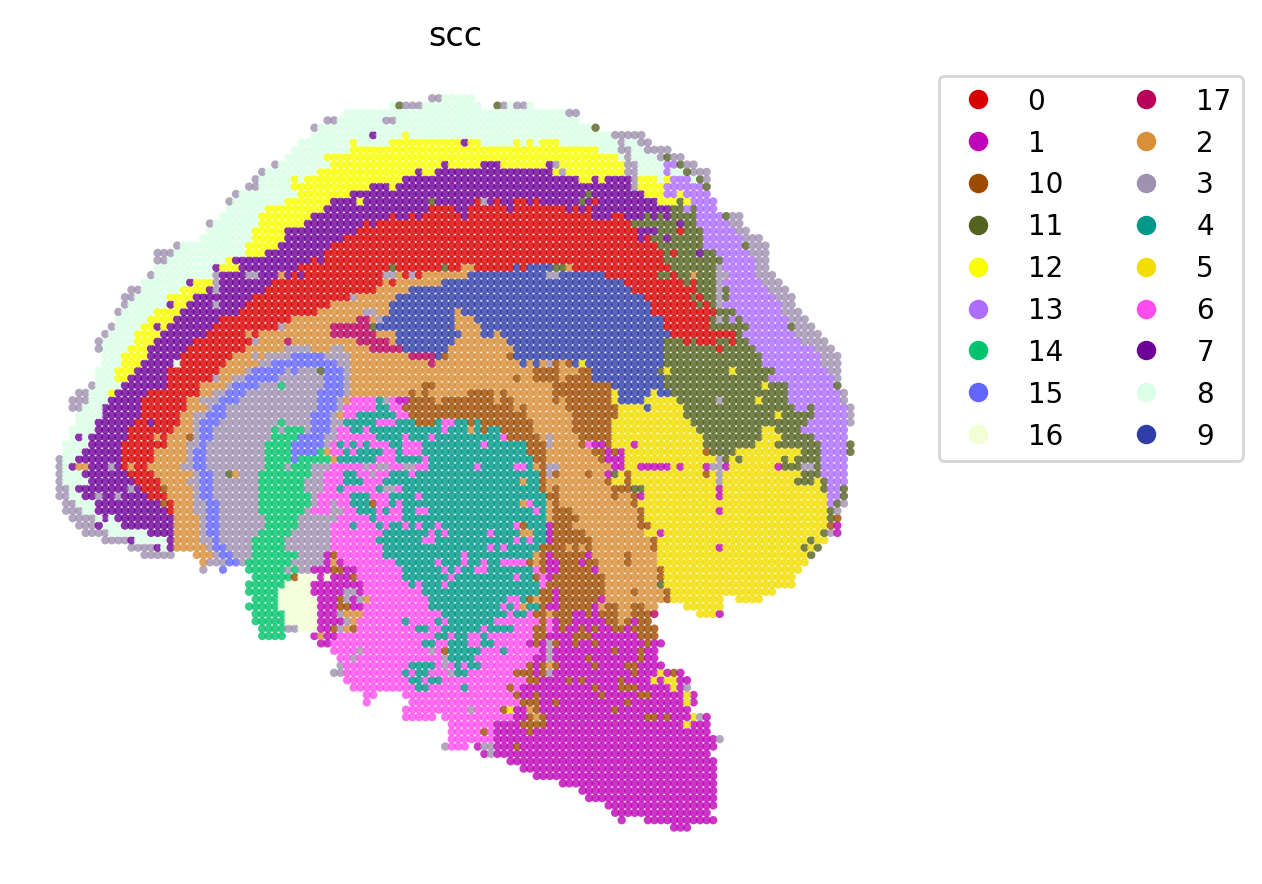

CPU times: user 25.6 s, sys: 97.4 ms, total: 25.7 s
Wall time: 25.4 s


In [129]:
#scc clustering
%%time
st.tl.scc(adata, s_neigh=8, e_neigh=30, resolution=0.35, cluster_method="louvain", key_added="scc", pca_key="X_pca")
st.pl.space(adata, color=['scc'], pointsize=0.2, show_legend="upper left")

In [131]:
%%time
adata_spagcn = st.tl.spagcn_pyg(adata,n_clusters=17)

|-----> Calculateing adj matrix using xy only...
|-----> Run 1: l [0.01, 1000], p [0.0, 1248.983102857965]
|-----> Run 2: l [0.01, 500.005], p [0.0, 369.67791748046875]
|-----> Run 3: l [0.01, 250.0075], p [0.0, 99.5406494140625]
|-----> Run 4: l [0.01, 125.00874999999999], p [0.0, 25.163841247558594]
|-----> Run 5: l [0.01, 62.509375], p [0.0, 5.67876672744751]
|-----> Run 6: l [0.01, 31.2596875], p [0.0, 0.724777102470398]
|-----> Run 7: l [15.63484375, 31.2596875], p [0.002495408058166504, 0.724777102470398]
|-----> Run 8: l [23.447265625, 31.2596875], p [0.15449857711791992, 0.724777102470398]
|-----> Run 9: l [27.3534765625, 31.2596875], p [0.3868889808654785, 0.724777102470398]
|-----> Run 10: l [27.3534765625, 29.30658203125], p [0.3868889808654785, 0.5439152717590332]
|-----> Run 11: l [28.330029296874997, 29.30658203125], p [0.4622429609298706, 0.5439152717590332]
|-----> recommended l = 28.8183056640625
|-----> Start at res = 0.7 step = 0.1
|-----> Initializing cluster center

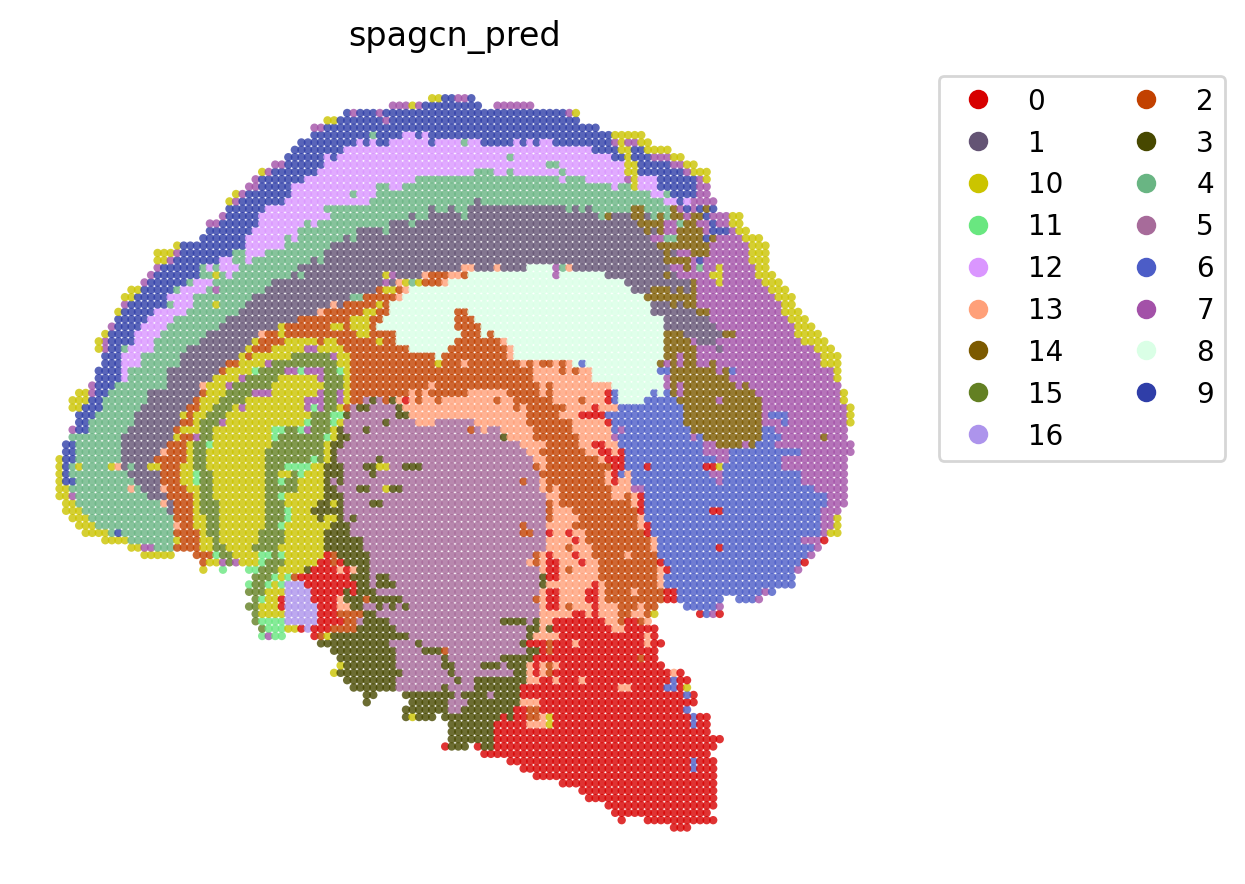

In [132]:
st.pl.space(adata, color=['spagcn_pred'], pointsize=0.2, show_legend="upper left")

In [133]:
adata.write("adata_bin60_cluster.h5ad", compression='gzip')

In [3]:
adata = anndata.read("adata_bin60_cluster.h5ad")